*   Network     : VGG16
*   Optimizer   : SGD
*   Regularizer : No regularization

Ref for code: https://github.com/geifmany/cifar-vgg/blob/master/cifar100vgg.py

In [ ]:
from __future__ import print_function

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras import callbacks

from keras.datasets import cifar100
from keras.layers.core import Lambda
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Loading cifar100 dataset and dividing into Train, Validation and Test sets

(X_train, Y_train), (x_test, y_test_o) = cifar100.load_data()

X_train = X_train.astype('float32')
x_test = x_test.astype('float32')

x_train, x_validation, y_train, y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

y_train = keras.utils.to_categorical(y_train, 100)
y_validation = keras.utils.to_categorical(y_validation, 100)
y_test = keras.utils.to_categorical(y_test_o, 100)

In [ ]:
#Definition of hyper parameters and other characteristics of the network like the activation functions

num_classes = 100
weight_decay = 0.0005
x_shape = [32,32,3]

conv_activation_func = 'elu'
dense_activation_func = 'elu'
ouput_activation_func = 'softmax'

batch_size = 128
maxepoches = 100
l_rate = 0.01
# lr_decay = 1e-6
# lr_drop = 20

In [ ]:
#Model definition of VGG16
def createModel():
  model = Sequential()
  weight_decay = 0.0005 #Hyper parameter

  model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_shape))
  model.add(Activation(conv_activation_func))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation(conv_activation_func))

  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Activation(conv_activation_func))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Activation(conv_activation_func))

  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(Activation(conv_activation_func))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(Activation(conv_activation_func))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(Activation(conv_activation_func))

  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(Activation(conv_activation_func))

  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(Activation(conv_activation_func))

  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(Activation(conv_activation_func))

  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # model.add(Conv2D(512, (3, 3), padding='same'))
  # model.add(Activation(conv_activation_func))

  # model.add(Conv2D(512, (3, 3), padding='same'))
  # model.add(Activation(conv_activation_func))

  # model.add(Conv2D(512, (3, 3), padding='same'))
  # model.add(Activation(conv_activation_func))

  # model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation(dense_activation_func))

  model.add(Dense(512))
  model.add(Activation(dense_activation_func))

  model.add(Dense(num_classes))
  model.add(Activation(ouput_activation_func))

  #Definition of SGD optimizer
  # sgd = optimizers.SGD(lr=l_rate, decay=lr_decay, momentum=0.9, nesterov=True)
  sgd = optimizers.SGD(learning_rate=l_rate)

  #Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

  return model

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [ ]:
#Creating an instance of the model

model = createModel()

In [ ]:
#Defintion of callbacks with EarlyStopping 

callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
#Definition of saving the best weights of the model with ModelCheckpoint

checkpoint_path = "checkpoints/VGGNet16_SGD_NoRegularization"
checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1, mode='min')
# checkpoint = callbacks.ModelCheckpoint('VGGNet16_SGD_NoRegularization.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1, mode='auto')

In [ ]:
#Training the model in the training dataset

history = model.fit(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_validation, y_validation),callbacks=[callback, checkpoint],verbose=2)

# history = model.fit(x_train, y_train, steps_per_epoch=x_train.shape[0] // batch_size, epochs=maxepoches, validation_data=(x_validation, y_validation), callbacks=[callback, checkpoint])
model.save_weights('VGGNet16_SGD_NoRegularization.h5')

Epoch 1/100

Epoch 00001: val_loss improved from inf to 3.77034, saving model to checkpoints/VGGNet16_SGD_NoRegularization
312/312 - 23s - loss: 4.1662 - accuracy: 0.0722 - val_loss: 3.7703 - val_accuracy: 0.1226
Epoch 2/100

Epoch 00002: val_loss improved from 3.77034 to 3.28177, saving model to checkpoints/VGGNet16_SGD_NoRegularization
312/312 - 23s - loss: 3.5928 - accuracy: 0.1562 - val_loss: 3.2818 - val_accuracy: 0.2067
Epoch 3/100

Epoch 00003: val_loss improved from 3.28177 to 3.10986, saving model to checkpoints/VGGNet16_SGD_NoRegularization
312/312 - 23s - loss: 3.2867 - accuracy: 0.2087 - val_loss: 3.1099 - val_accuracy: 0.2432
Epoch 4/100

Epoch 00004: val_loss improved from 3.10986 to 2.89091, saving model to checkpoints/VGGNet16_SGD_NoRegularization
312/312 - 23s - loss: 3.0618 - accuracy: 0.2499 - val_loss: 2.8909 - val_accuracy: 0.2825
Epoch 5/100

Epoch 00005: val_loss improved from 2.89091 to 2.79816, saving model to checkpoints/VGGNet16_SGD_NoRegularization
312/312 -

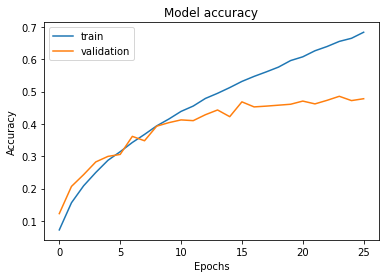

In [ ]:
#Plot the Training and Validation accuracy v/s Epochs
#history.keys() = ['accuracy', 'loss', 'val_accuracy', 'val_loss']

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

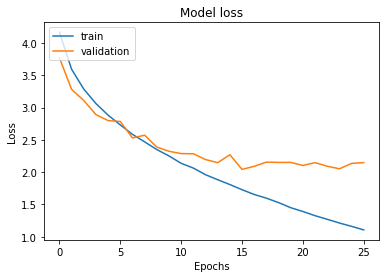

In [ ]:
#Plot the Training and Validation loss v/s Epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#Testing the model using the best weights of the model
import os
model_test = createModel()
model_test.load_weights('./VGGNet16_SGD_NoRegularization.h5')
# model_test.load_weights(checkpoint_path)
# model_test.load_weights('VGGNet16_SGD_NoRegularization.h5')
loss, acc = model_test.evaluate(x_test,  y_test, verbose=2)
# print(loss, acc)

# predict classes for test set
predict_y_test = model_test.predict_classes(x_test, verbose=0)

313/313 - 2s - loss: 2.1024 - accuracy: 0.4973
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
#Precision, recall and accuracy of the model on test data
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_o, predict_y_test)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test_o, predict_y_test, average='macro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test_o, predict_y_test, average='macro')
print('Recall: %f' % recall)

# Confusion matrix
confusion_matrix_ = confusion_matrix(y_test_o, predict_y_test)
print(confusion_matrix_)

Accuracy: 0.497300
Precision: 0.526244
Recall: 0.497300
[[75  0  1 ...  0  0  0]
 [ 0 57  0 ...  1  0  3]
 [ 1  0 39 ...  0  6  0]
 ...
 [ 0  1  0 ... 52  0  0]
 [ 0  1  6 ...  1 33  1]
 [ 0  0  0 ...  0  0 47]]


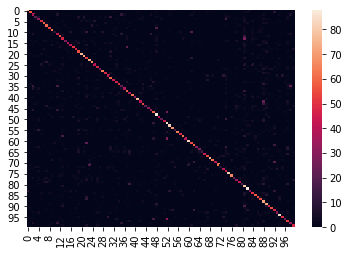

In [ ]:
import seaborn as sb
heat_map = sb.heatmap(confusion_matrix_)
plt.show()